<center>
<h1><b>Fraud Analytics - 2025</b> </h1>
<h2><b>Assignment 4: Generate Synthetic Data using GAN</b></h2>
</center>

---
----

Team Members:-
#### Sakshi Badole : CS24MTECH11008 
#### Laveena Herman : CS24MTECH11010 
#### S Anjana Shankar : CS24MTECH14015
------

# Synthetic Data Generation with GAN

This notebook implements a **Generative Adversarial Network (GAN)** to generate synthetic data that mimics the statistical properties of a given dataset. The code includes data preprocessing, model training, synthetic data generation, and comprehensive visualization of results.

## Overview
- **Objective**: Generate synthetic data that preserves the distribution and correlation structure of the input data.
- **Dataset**: Loaded from `data.xlsx`, with 1199 rows and 10 features.
- **Model**: A GAN with an improved Generator and Discriminator, incorporating correlation and distribution matching losses.
- **Environment**: Utilizes GPU (CUDA) if available for faster training.

## Structure
1. **Imports and Setup**: Load libraries and configure the environment.
2. **Data Loading and Preprocessing**: Load and preprocess the dataset.
3. **Model Definition**: Define the Generator and Discriminator architectures.
4. **Training**: Train the GAN with enhanced stability checks.
5. **Synthetic Data Generation**: Generate synthetic samples.
6. **Visualization**: Plot distributions, correlations, and training metrics.
7. **Metrics Calculation**: Compute correlation differences and Wasserstein distances.
8. **Save Results**: Save the synthetic data to a CSV file.

Let's dive into the implementation!

## Imports and Environment Setup

This section imports necessary libraries and sets up the environment for reproducibility and GPU usage.

- **Libraries**: Pandas, NumPy, Matplotlib, Seaborn, PyTorch, Scikit-learn, SciPy, TQDM, etc.
- **Random Seeds**: Set for reproducibility.
- **Device**: Configures CUDA if available for faster computation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.stats import wasserstein_distance
import time
from tqdm import tqdm
import gc
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(326)
torch.manual_seed(326)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True


Using device: cuda


## Data Loading

Load the input dataset from `data.xlsx` and display its shape.

- **File**: `data.xlsx`
- **Output**: Prints the shape of the dataset (e.g., `(1199, 10)`).

In [2]:
# Load data
df = pd.read_excel('data.xlsx')
print("Original data shape:", df.shape)

# Clear memory
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()


Original data shape: (1199, 10)


##  Utility Function - Safe Correlation

Define a function to compute the correlation matrix safely, handling zero standard deviations and NaN values.

In [ ]:
def safe_correlation(data, epsilon=1e-8):

    data = np.array(data)
    means = np.mean(data, axis=0)
    centered_data = data - means
    std = np.std(data, axis=0)

    # Ensure no zero standard deviations
    valid_features = std > epsilon
    if not np.all(valid_features):
        print(f"Warning: {np.sum(~valid_features)} features have zero std deviation")
        std[~valid_features] = 1.0

    normalized = centered_data / std
    n = data.shape[0]

    # Calculate correlation with nan protection
    corr = np.dot(normalized.T, normalized) / n
    np.fill_diagonal(corr, 1.0)

    return corr


##  Data Preprocessing

Preprocess the data using **RobustScaler** and **StandardScaler**, clip extreme values, compute correlations, and prepare PyTorch tensors for training.

- **Scalers**: RobustScaler for outlier handling, StandardScaler for normalization.
- **Clipping**: Limits values to `[-5, 5]` to prevent numerical instability.
- **Correlation**: Compute the correlation matrix of the original data.
- **DataLoader**: Create a PyTorch DataLoader for batched training.

In [ ]:
# ENHANCED DATA PREPROCESSING with Robust Scaler for better outlier handling
# First use RobustScaler to handle outliers
robust_scaler = RobustScaler()
robust_scaled = robust_scaler.fit_transform(df)

# Then use StandardScaler for normalization
standard_scaler = StandardScaler()
scaled_data = standard_scaler.fit_transform(robust_scaled)

# Completely clip extreme values to prevent numerical instabilities
scaled_data = np.clip(scaled_data, -5, 5)

# Compute feature correlations from original data
original_corr = safe_correlation(df.values)

# Convert to PyTorch tensors
tensor_data = torch.FloatTensor(scaled_data).to(device)
dataset = TensorDataset(tensor_data)

# Batch size
batch_size = min(64, len(tensor_data))  # Smaller batch size for more stable training
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


##  Model Dimensions

Define the dimensions for the GAN model.

- **Latent Dimension**: 100, for a more expressive latent space.
- **Feature Dimension**: Matches the number of features in the dataset.

In [5]:
# Model dimensions
latent_dim = 100  # Larger latent space for more expressive power
feature_dim = df.shape[1]


##  Generator Model

Define the **Generator** class, which maps a latent vector to synthetic data.

- **Architecture**: Multiple linear layers with BatchNorm and LeakyReLU activations.
- **Initialization**: Uses Xavier initialization for better gradient flow.

In [ ]:
class Generator(nn.Module):

    def __init__(self, latent_dim, feature_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, feature_dim)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, z):

        return self.model(z)


## Discriminator Model

Define the **Discriminator** class, which distinguishes real data from synthetic data.

- **Architecture**: Linear layers with LayerNorm, LeakyReLU, and Dropout for stability.
- **Initialization**: Uses Xavier initialization for better gradient flow.

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, feature_dim):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(128, 1),
            nn.Sigmoid()
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):

        return self.model(x)


##  Model and Training Setup

Initialize the Generator and Discriminator, set up optimizers, and define loss functions.

- **Models**: Move to GPU if available.
- **Optimizers**: Adam with weight decay for regularization.
- **Loss**: Binary Cross-Entropy for adversarial loss.

In [8]:
# Initialize models
generator = Generator(latent_dim, feature_dim).to(device)
discriminator = Discriminator(feature_dim).to(device)

# Optimizers with weight decay for regularization
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=1e-5)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=1e-5)

# Loss functions
adversarial_loss = nn.BCELoss()


##  Correlation Loss Function

Define a function to compute the correlation loss between generated and real data correlations.

In [ ]:
def correlation_loss(generated, original_corr):

    batch_np = generated.detach().cpu().numpy()

    # Skip if batch is too small
    if batch_np.shape[0] < 2:
        return torch.tensor(0.0, device=device)

    # Remove any rows with nan or inf values
    valid_rows = ~np.isnan(batch_np).any(axis=1) & ~np.isinf(batch_np).any(axis=1)

    if not np.any(valid_rows):
        return torch.tensor(1.0, device=device)  # Return high loss if all rows are invalid

    batch_np = batch_np[valid_rows]

    try:
        # Calculate correlation with protection
        batch_corr = safe_correlation(batch_np)

        # Check for nan values
        if np.isnan(batch_corr).any():
            return torch.tensor(1.0, device=device)  # Return high loss if correlation is nan

        # Calculate loss
        loss_value = np.mean((batch_corr - original_corr) ** 2)

        return torch.tensor(loss_value, device=device)
    except Exception as e:
        print(f"Error in correlation calculation: {e}")
        return torch.tensor(1.0, device=device)


##  Distribution Matching Loss Function

Define a function to compute the distribution matching loss based on mean and standard deviation.

In [ ]:
def distribution_matching_loss(fake, real):

    # Use the first moments for matching
    mean_loss = torch.mean((torch.mean(fake, dim=0) - torch.mean(real, dim=0)) ** 2)
    std_loss = torch.mean((torch.std(fake, dim=0) - torch.std(real, dim=0)) ** 2)

    # Add protection against nan
 

    if torch.isnan(mean_loss) or torch.isnan(std_loss):
        return torch.tensor(0.0, device=device)

    return mean_loss + std_loss


##  GAN Training Function

Define the function to train the GAN, including stability checks and dynamic learning rate adjustments.

In [ ]:
def train_gan(generator, discriminator, dataloader, epochs=2000, sample_interval=100):

    start_time = time.time()
    d_losses = []
    g_losses = []
    corr_losses = []
    w_losses = []

    # Dynamic learning rate adjustment
    g_lr_scheduler = optim.lr_scheduler.StepLR(g_optimizer, step_size=500, gamma=0.5)
    d_lr_scheduler = optim.lr_scheduler.StepLR(d_optimizer, step_size=500, gamma=0.5)

    # Loss weights
    correlation_weight = 10.0
    distribution_weight = 5.0

    print("Starting GAN training...")

    for epoch in tqdm(range(epochs), desc="Training epochs"):
        epoch_d_losses = []
        epoch_g_losses = []
        epoch_corr_losses = []
        epoch_w_losses = []

        for batch_idx, real_data in enumerate(dataloader):
            current_batch_size = real_data[0].size(0)
            real_data = real_data[0]

            # Labels for adversarial loss
            valid = torch.ones(current_batch_size, 1, device=device)
            fake = torch.zeros(current_batch_size, 1, device=device)

            # Train Discriminator
            d_optimizer.zero_grad()

            # Real samples
            real_pred = discriminator(real_data)
            d_real_loss = adversarial_loss(real_pred, valid)

            # Generated samples
            z = torch.randn(current_batch_size, latent_dim, device=device)
            generated_data = generator(z)
            fake_pred = discriminator(generated_data.detach())
            d_fake_loss = adversarial_loss(fake_pred, fake)

            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2

            # Check for nan in discriminator loss
            if not torch.isnan(d_loss):
                d_loss.backward()
                torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1.0)
                d_optimizer.step()

            epoch_d_losses.append(d_loss.item())

            # Train Generator
            g_optimizer.zero_grad()

            # Generate new batch
            z = torch.randn(current_batch_size, latent_dim, device=device)
            generated_data = generator(z)

            # Adversarial loss
            validity = discriminator(generated_data)
            g_adversarial_loss = adversarial_loss(validity, valid)

            # Correlation loss
            corr_loss = correlation_loss(generated_data, original_corr) * correlation_weight

            # Distribution matching loss
            dist_loss = distribution_matching_loss(generated_data, real_data) * distribution_weight

            # Total generator loss
            g_loss = g_adversarial_loss + corr_loss + dist_loss

            # Check for nan in generator loss
            if not torch.isnan(g_loss):
                g_loss.backward()
                torch.nn.utils.clip_grad_norm_(generator.parameters(), 1.0)
                g_optimizer.step()

            # Calculate Wasserstein distance
            real_np = real_data.detach().cpu().numpy()
            fake_np = generated_data.detach().cpu().numpy()
            w_distances = []
            for i in range(real_np.shape[1]):
                try:
                    w_dist = wasserstein_distance(real_np[:, i], fake_np[:, i])
                    if not np.isnan(w_dist):
                        w_distances.append(w_dist)
                except:
                    continue

            if w_distances:
                w_loss = np.mean(w_distances)
            else:
                w_loss = np.nan

            epoch_corr_losses.append(corr_loss.item())
            epoch_w_losses.append(w_loss)
            epoch_g_losses.append(g_adversarial_loss.item())

        # Update learning rates
        g_lr_scheduler.step()
        d_lr_scheduler.step()

        # Calculate average losses for this epoch
        avg_d_loss = sum(epoch_d_losses) / max(1, len(epoch_d_losses))
        avg_g_loss = sum(epoch_g_losses) / max(1, len(epoch_g_losses))
        avg_corr_loss = sum(epoch_corr_losses) / max(1, len(epoch_corr_losses))

        # Handle nan values in average calculations
        valid_w_losses = [w for w in epoch_w_losses if not np.isnan(w)]
        if valid_w_losses:
            avg_w_loss = sum(valid_w_losses) / len(valid_w_losses)
        else:
            avg_w_loss = np.nan

        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)
        corr_losses.append(avg_corr_loss)
        w_losses.append(avg_w_loss)

        # Adjust weights based on loss values
        if epoch > 200 and avg_corr_loss > 0.1:
            correlation_weight = min(20.0, correlation_weight * 1.1)
        if epoch > 200 and avg_w_loss > 0.15:
            distribution_weight = min(10.0, distribution_weight * 1.1)

        if epoch % sample_interval == 0:
            print(f"Epoch {epoch}/{epochs} - D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}, "
                  f"Corr Loss: {avg_corr_loss:.4f}, W Loss: {avg_w_loss:.4f}")

        # Save generator model periodically
        if epoch % 500 == 0 and epoch > 0:
            torch.save(generator.state_dict(), f'generator_epoch_{epoch}.pth')

    print(f"Training completed in {(time.time() - start_time) / 60:.2f} minutes")
    return d_losses, g_losses, corr_losses, w_losses


##  Synthetic Data Generation Function

Define a function to generate synthetic data using the trained generator.

In [ ]:
@torch.no_grad()
def generate_synthetic_data(generator, latent_dim, n_samples, robust_scaler, standard_scaler, device, df):

    start_time = time.time()
    print("Starting synthetic data generation...")
    generator.eval()

    synthetic_samples = []
    batch_size = min(1000, n_samples)

    max_attempts = 10  # Maximum number of regeneration attempts

    for i in tqdm(range(0, n_samples, batch_size), desc="Generating batches"):
        current_samples = min(batch_size, n_samples - i)

        attempts = 0
        while attempts < max_attempts:
            noise = torch.randn(current_samples, latent_dim, device=device)
            generated = generator(noise).cpu().numpy()

            # Check for invalid values
            valid_samples = ~np.isnan(generated).any(axis=1) & ~np.isinf(generated).any(axis=1)
            if np.all(valid_samples):
                synthetic_samples.append(generated)
                break
            else:
                # Only keep valid samples
                if np.any(valid_samples):
                    synthetic_samples.append(generated[valid_samples])
                # Regenerate invalid samples
                current_samples -= np.sum(valid_samples)
                attempts += 1

        if attempts == max_attempts:
            print(f"Warning: Could not generate all samples after {max_attempts} attempts")

    synthetic_scaled = np.vstack(synthetic_samples)

    print(f"Inverse transforming data...")
    # Inverse transform through each scaler
    synthetic_data = standard_scaler.inverse_transform(synthetic_scaled)
    synthetic_data = robust_scaler.inverse_transform(synthetic_data)

    # Create DataFrame
    synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns)

    # Final check for valid values
    valid_rows = ~synthetic_df.isna().any(axis=1) & ~np.isinf(synthetic_df).any(axis=1)
    if not np.all(valid_rows):
        print(f"Warning: {np.sum(~valid_rows)} rows contain invalid values. Removing...")
        synthetic_df = synthetic_df[valid_rows]

    print(f"Data generation completed in {time.time() - start_time:.2f} seconds")

    return synthetic_df


##  Distribution Plotting Function

Define a function to plot the distributions of real and synthetic data, including enhanced statistics.

In [ ]:
def plot_distributions(real_df, synthetic_df, save_path='improved_feature_distributions.png'):

    start_time = time.time()
    print("Plotting distributions...")

    n_features = real_df.shape[1]
    n_cols = min(3, n_features)
    n_rows = (n_features + n_cols - 1) // n_cols

    plt.figure(figsize=(15, 5 * n_rows))

    for i, feature in enumerate(tqdm(real_df.columns, desc="Creating distribution plots")):
        plt.subplot(n_rows, n_cols, i+1)

        # Remove nan values before plotting
        real_data = real_df[feature].dropna()
        synth_data = synthetic_df[feature].dropna()

        if len(real_data) > 0 and len(synth_data) > 0:
            # Remove outliers for better visualization
            real_q1, real_q3 = np.percentile(real_data, [5, 95])
            synth_q1, synth_q3 = np.percentile(synth_data, [5, 95])

            real_filtered = real_data[(real_data >= real_q1) & (real_data <= real_q3)]
            synth_filtered = synth_data[(synth_data >= synth_q1) & (synth_data <= synth_q3)]

            # Plot KDE
            sns.kdeplot(real_filtered, label='Real', color='blue', alpha=0.7, fill=True)
            sns.kdeplot(synth_filtered, label='Synthetic', color='red', alpha=0.7, fill=True)

            # Calculate statistics
            real_mean = np.mean(real_data)
            synth_mean = np.mean(synth_data)
            real_std = np.std(real_data)
            synth_std = np.std(synth_data)
            real_median = np.median(real_data)
            synth_median = np.median(synth_data)

            # Calculate Wasserstein distance
            try:
                wd = wasserstein_distance(real_data, synth_data)
                if not np.isnan(wd):
                    wd_text = f'W-dist: {wd:.4f}'
                else:
                    wd_text = 'W-dist: nan'
            except:
                wd_text = 'W-dist: error'

            # Create statistics text
            stats_text = (
                f'Real:\nμ={real_mean:.2f}\nσ={real_std:.2f}\nMed={real_median:.2f}\n'
                f'Synthetic:\nμ={synth_mean:.2f}\nσ={synth_std:.2f}\nMed={synth_median:.2f}\n'
                f'{wd_text}'
            )

            # Add statistics text to plot
            plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
                     verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.5))

        plt.title(f'Distribution of {feature}')
        plt.legend()

    plt.tight_layout()
    plt.show()
    print(f"Distribution plotting completed in {time.time() - start_time:.2f} seconds")


##  Correlation Comparison Plotting Function

Define a function to plot correlation matrices and their differences, including Q-Q plots.

In [ ]:
def plot_correlation_comparison(real_df, synthetic_df, save_path='improved_correlation_comparison.png'):

    start_time = time.time()
    print("Plotting correlation comparison...")

    real_corr = pd.DataFrame(
        safe_correlation(real_df.values),
        index=real_df.columns,
        columns=real_df.columns
    )
    synthetic_corr = pd.DataFrame(
        safe_correlation(synthetic_df.values),
        index=synthetic_df.columns,
        columns=synthetic_df.columns
    )

    fig_size = max(10, real_df.shape[1] // 2)

    fig, axs = plt.subplots(1, 2, figsize=(fig_size * 2, fig_size))

    sns.heatmap(real_corr, annot=True, cmap='coolwarm', fmt=".2f", ax=axs[0], vmin=-1, vmax=1)
    axs[0].set_title('Real Data Correlation Matrix')

    sns.heatmap(synthetic_corr, annot=True, cmap='coolwarm', fmt=".2f", ax=axs[1], vmin=-1, vmax=1)
    axs[1].set_title('Synthetic Data Correlation Matrix')

    plt.tight_layout()
    plt.show()

    diff_corr = real_corr - synthetic_corr
    abs_diff = np.abs(diff_corr)

    plt.figure(figsize=(fig_size, fig_size))

    g = sns.heatmap(diff_corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

    mean_abs_diff = abs_diff.mean().mean()
    plt.title(f'Correlation Difference (Real - Synthetic)\nMean Abs Diff: {mean_abs_diff:.4f}')

    plt.tight_layout()
    plt.show()

    print(f"Correlation plotting completed in {time.time() - start_time:.2f} seconds")

    # Q-Q plots
    print("Creating Q-Q plots...")
    n_features = len(real_df.columns)
    max_features_per_plot = 6

    for j in range(0, n_features, max_features_per_plot):
        end_j = min(j + max_features_per_plot, n_features)
        current_features = real_df.columns[j:end_j]
        n_current = len(current_features)

        plt.figure(figsize=(15, 3 * ((n_current + 2) // 3)))

        for i, feature in enumerate(current_features):
            plt.subplot((n_current + 2) // 3, 3, i+1)

            real_quantiles = np.quantile(real_df[feature], np.linspace(0, 1, 100))
            synth_quantiles = np.quantile(synthetic_df[feature], np.linspace(0, 1, 100))

            plt.scatter(real_quantiles, synth_quantiles, alpha=0.7)
            min_val = min(real_quantiles.min(), synth_quantiles.min())
            max_val = max(real_quantiles.max(), synth_quantiles.max())
            plt.plot([min_val, max_val], [min_val, max_val], 'r--')
            plt.xlabel('Real Data Quantiles')
            plt.ylabel('Synthetic Data Quantiles')
            plt.title(f'Q-Q Plot for {feature}')

        plt.tight_layout()
        plt.show()

    print(f"QQ-plot creation completed in {time.time() - start_time:.2f} seconds")


##  Training Metrics Plotting Function

Define a function to plot training metrics, including losses and Wasserstein distance.

In [ ]:
def plot_training_metrics(d_losses, g_losses, corr_losses, w_losses):

    start_time = time.time()
    print("Plotting training metrics...")

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.legend()
    plt.title('GAN Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(2, 2, 2)
    plt.plot(corr_losses, label='Correlation Loss')
    plt.title('Correlation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(2, 2, 3)
    plt.plot(w_losses, label='Wasserstein Distance')
    plt.title('Wasserstein Distance')
    plt.xlabel('Epoch')
    plt.ylabel('Wasserstein Distance')
    plt.xlabel('Epoch')
    plt.ylabel('Distance')

    plt.subplot(2, 2, 4)
    start_idx = len(d_losses) // 10
    plt.plot(d_losses[start_idx:], label='D Loss (later epochs)')
    plt.plot(g_losses[start_idx:], label='G Loss (later epochs)')
    plt.legend()
    plt.title('Convergence Trend (Later Epochs)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()
    print(f"Metrics plotting completed in {time.time() - start_time:.2f} seconds")


##  Train the GAN

Train the GAN model for 5000 epochs and collect training metrics.

- **Epochs**: 5000 for thorough training.
- **Output**: Loss metrics and periodic model checkpoints.

In [17]:
print("\nTraining improved GAN model...")
d_losses, g_losses, corr_losses, w_losses = train_gan(generator, discriminator, dataloader, epochs=5000)



Training improved GAN model...
Starting GAN training...


Training epochs:   0%|          | 1/5000 [00:01<2:16:10,  1.63s/it]

Epoch 0/5000 - D Loss: 0.6777, G Loss: 1.1293, Corr Loss: 0.4826, W Loss: 0.4964


Training epochs:   2%|▏         | 101/5000 [00:28<20:57,  3.90it/s]

Epoch 100/5000 - D Loss: 0.3747, G Loss: 1.8521, Corr Loss: 0.2575, W Loss: 0.2288


Training epochs:   4%|▍         | 201/5000 [00:55<21:34,  3.71it/s]

Epoch 200/5000 - D Loss: 0.3718, G Loss: 1.8453, Corr Loss: 0.3302, W Loss: 0.2145


Training epochs:   6%|▌         | 301/5000 [01:21<19:18,  4.06it/s]

Epoch 300/5000 - D Loss: 0.3059, G Loss: 2.1260, Corr Loss: 0.7432, W Loss: 0.2257


Training epochs:   8%|▊         | 401/5000 [01:46<18:16,  4.20it/s]

Epoch 400/5000 - D Loss: 0.3744, G Loss: 1.9656, Corr Loss: 0.6723, W Loss: 0.2156


Training epochs:  10%|█         | 501/5000 [02:13<20:25,  3.67it/s]

Epoch 500/5000 - D Loss: 0.3851, G Loss: 1.7787, Corr Loss: 0.6413, W Loss: 0.2039


Training epochs:  12%|█▏        | 601/5000 [02:38<17:13,  4.26it/s]

Epoch 600/5000 - D Loss: 0.4628, G Loss: 1.5822, Corr Loss: 0.6269, W Loss: 0.1835


Training epochs:  14%|█▍        | 701/5000 [03:02<17:04,  4.20it/s]

Epoch 700/5000 - D Loss: 0.4467, G Loss: 1.5754, Corr Loss: 0.5694, W Loss: 0.1837


Training epochs:  16%|█▌        | 801/5000 [03:26<16:53,  4.14it/s]

Epoch 800/5000 - D Loss: 0.4737, G Loss: 1.6080, Corr Loss: 0.6300, W Loss: 0.1797


Training epochs:  18%|█▊        | 901/5000 [03:50<16:42,  4.09it/s]

Epoch 900/5000 - D Loss: 0.4770, G Loss: 1.4631, Corr Loss: 0.5798, W Loss: 0.1859


Training epochs:  20%|██        | 1001/5000 [04:21<20:36,  3.23it/s]

Epoch 1000/5000 - D Loss: 0.5464, G Loss: 1.2970, Corr Loss: 0.5506, W Loss: 0.1753


Training epochs:  22%|██▏       | 1101/5000 [04:47<16:08,  4.03it/s]

Epoch 1100/5000 - D Loss: 0.5855, G Loss: 1.1155, Corr Loss: 0.5175, W Loss: 0.1588


Training epochs:  24%|██▍       | 1201/5000 [05:11<14:33,  4.35it/s]

Epoch 1200/5000 - D Loss: 0.5735, G Loss: 1.1835, Corr Loss: 0.5075, W Loss: 0.1648


Training epochs:  26%|██▌       | 1301/5000 [05:35<15:03,  4.10it/s]

Epoch 1300/5000 - D Loss: 0.5674, G Loss: 1.1373, Corr Loss: 0.4862, W Loss: 0.1544


Training epochs:  28%|██▊       | 1401/5000 [05:59<13:47,  4.35it/s]

Epoch 1400/5000 - D Loss: 0.5663, G Loss: 1.1487, Corr Loss: 0.4829, W Loss: 0.1508


Training epochs:  30%|███       | 1500/5000 [06:24<13:26,  4.34it/s]

Epoch 1500/5000 - D Loss: 0.6383, G Loss: 1.0058, Corr Loss: 0.4637, W Loss: 0.1539


Training epochs:  32%|███▏      | 1601/5000 [06:48<13:45,  4.12it/s]

Epoch 1600/5000 - D Loss: 0.6354, G Loss: 0.9326, Corr Loss: 0.4268, W Loss: 0.1490


Training epochs:  34%|███▍      | 1701/5000 [07:19<15:05,  3.64it/s]

Epoch 1700/5000 - D Loss: 0.6429, G Loss: 0.8847, Corr Loss: 0.4001, W Loss: 0.1484


Training epochs:  36%|███▌      | 1801/5000 [07:43<12:42,  4.19it/s]

Epoch 1800/5000 - D Loss: 0.6393, G Loss: 0.9190, Corr Loss: 0.4393, W Loss: 0.1468


Training epochs:  38%|███▊      | 1901/5000 [08:13<28:33,  1.81it/s]

Epoch 1900/5000 - D Loss: 0.6361, G Loss: 0.8963, Corr Loss: 0.3803, W Loss: 0.1465


Training epochs:  40%|████      | 2001/5000 [08:43<13:25,  3.72it/s]

Epoch 2000/5000 - D Loss: 0.6578, G Loss: 0.8727, Corr Loss: 0.4098, W Loss: 0.1417


Training epochs:  42%|████▏     | 2101/5000 [09:08<12:36,  3.83it/s]

Epoch 2100/5000 - D Loss: 0.6531, G Loss: 0.8085, Corr Loss: 0.4327, W Loss: 0.1382


Training epochs:  44%|████▍     | 2201/5000 [09:34<14:49,  3.15it/s]

Epoch 2200/5000 - D Loss: 0.6606, G Loss: 0.8103, Corr Loss: 0.3784, W Loss: 0.1480


Training epochs:  46%|████▌     | 2301/5000 [10:00<12:20,  3.64it/s]

Epoch 2300/5000 - D Loss: 0.6540, G Loss: 0.8097, Corr Loss: 0.3352, W Loss: 0.1432


Training epochs:  48%|████▊     | 2401/5000 [10:26<12:03,  3.59it/s]

Epoch 2400/5000 - D Loss: 0.6544, G Loss: 0.8140, Corr Loss: 0.3560, W Loss: 0.1353


Training epochs:  50%|█████     | 2501/5000 [10:52<10:10,  4.09it/s]

Epoch 2500/5000 - D Loss: 0.6526, G Loss: 0.8241, Corr Loss: 0.3735, W Loss: 0.1414


Training epochs:  52%|█████▏    | 2601/5000 [11:17<09:53,  4.04it/s]

Epoch 2600/5000 - D Loss: 0.6598, G Loss: 0.8119, Corr Loss: 0.4412, W Loss: 0.1379


Training epochs:  54%|█████▍    | 2701/5000 [11:43<09:23,  4.08it/s]

Epoch 2700/5000 - D Loss: 0.6625, G Loss: 0.8093, Corr Loss: 0.4065, W Loss: 0.1348


Training epochs:  56%|█████▌    | 2801/5000 [12:08<09:46,  3.75it/s]

Epoch 2800/5000 - D Loss: 0.6613, G Loss: 0.8012, Corr Loss: 0.4011, W Loss: 0.1398


Training epochs:  58%|█████▊    | 2901/5000 [12:37<11:12,  3.12it/s]

Epoch 2900/5000 - D Loss: 0.6610, G Loss: 0.7996, Corr Loss: 0.3868, W Loss: 0.1409


Training epochs:  60%|██████    | 3001/5000 [13:04<09:04,  3.67it/s]

Epoch 3000/5000 - D Loss: 0.6597, G Loss: 0.7915, Corr Loss: 0.3786, W Loss: 0.1426


Training epochs:  62%|██████▏   | 3101/5000 [13:32<08:33,  3.70it/s]

Epoch 3100/5000 - D Loss: 0.6624, G Loss: 0.8013, Corr Loss: 0.3667, W Loss: 0.1449


Training epochs:  64%|██████▍   | 3201/5000 [14:02<08:58,  3.34it/s]

Epoch 3200/5000 - D Loss: 0.6602, G Loss: 0.7928, Corr Loss: 0.4510, W Loss: 0.1424


Training epochs:  66%|██████▌   | 3301/5000 [14:31<07:53,  3.59it/s]

Epoch 3300/5000 - D Loss: 0.6630, G Loss: 0.8193, Corr Loss: 0.3389, W Loss: 0.1447


Training epochs:  68%|██████▊   | 3401/5000 [15:00<07:14,  3.68it/s]

Epoch 3400/5000 - D Loss: 0.6560, G Loss: 0.7959, Corr Loss: 0.3421, W Loss: 0.1405


Training epochs:  70%|███████   | 3500/5000 [15:27<06:16,  3.99it/s]

Epoch 3500/5000 - D Loss: 0.6796, G Loss: 0.8188, Corr Loss: 0.3548, W Loss: 0.1357


Training epochs:  72%|███████▏  | 3601/5000 [15:56<05:48,  4.01it/s]

Epoch 3600/5000 - D Loss: 0.6623, G Loss: 0.7871, Corr Loss: 0.4012, W Loss: 0.1366


Training epochs:  74%|███████▍  | 3701/5000 [16:23<06:38,  3.26it/s]

Epoch 3700/5000 - D Loss: 0.6578, G Loss: 0.7884, Corr Loss: 0.4014, W Loss: 0.1421


Training epochs:  76%|███████▌  | 3801/5000 [16:52<06:25,  3.11it/s]

Epoch 3800/5000 - D Loss: 0.6669, G Loss: 0.8067, Corr Loss: 0.3264, W Loss: 0.1423


Training epochs:  78%|███████▊  | 3901/5000 [17:17<03:58,  4.60it/s]

Epoch 3900/5000 - D Loss: 0.6629, G Loss: 0.7983, Corr Loss: 0.4052, W Loss: 0.1344


Training epochs:  80%|████████  | 4000/5000 [17:40<04:41,  3.55it/s]

Epoch 4000/5000 - D Loss: 0.6713, G Loss: 0.7887, Corr Loss: 0.3945, W Loss: 0.1543


Training epochs:  82%|████████▏ | 4101/5000 [18:04<03:51,  3.88it/s]

Epoch 4100/5000 - D Loss: 0.6715, G Loss: 0.7832, Corr Loss: 0.4115, W Loss: 0.1411


Training epochs:  84%|████████▍ | 4201/5000 [18:29<03:07,  4.27it/s]

Epoch 4200/5000 - D Loss: 0.6614, G Loss: 0.7915, Corr Loss: 0.3952, W Loss: 0.1408


Training epochs:  86%|████████▌ | 4301/5000 [18:52<02:36,  4.46it/s]

Epoch 4300/5000 - D Loss: 0.6622, G Loss: 0.7956, Corr Loss: 0.4234, W Loss: 0.1385


Training epochs:  88%|████████▊ | 4401/5000 [19:17<02:22,  4.21it/s]

Epoch 4400/5000 - D Loss: 0.6608, G Loss: 0.7951, Corr Loss: 0.4112, W Loss: 0.1368


Training epochs:  90%|█████████ | 4501/5000 [19:41<01:56,  4.28it/s]

Epoch 4500/5000 - D Loss: 0.6665, G Loss: 0.7900, Corr Loss: 0.3659, W Loss: 0.1312


Training epochs:  92%|█████████▏| 4601/5000 [20:07<01:34,  4.24it/s]

Epoch 4600/5000 - D Loss: 0.6715, G Loss: 0.7826, Corr Loss: 0.4073, W Loss: 0.1366


Training epochs:  94%|█████████▍| 4701/5000 [20:31<01:06,  4.51it/s]

Epoch 4700/5000 - D Loss: 0.6722, G Loss: 0.7931, Corr Loss: 0.3817, W Loss: 0.1317


Training epochs:  96%|█████████▌| 4801/5000 [20:55<00:48,  4.07it/s]

Epoch 4800/5000 - D Loss: 0.6645, G Loss: 0.7936, Corr Loss: 0.3848, W Loss: 0.1363


Training epochs:  98%|█████████▊| 4901/5000 [21:23<00:28,  3.45it/s]

Epoch 4900/5000 - D Loss: 0.6672, G Loss: 0.7870, Corr Loss: 0.3831, W Loss: 0.1333


Training epochs: 100%|██████████| 5000/5000 [21:47<00:00,  3.82it/s]

Training completed in 21.79 minutes


##  Plot Training Metrics

Visualize the training metrics to assess model convergence.

Plotting training metrics...


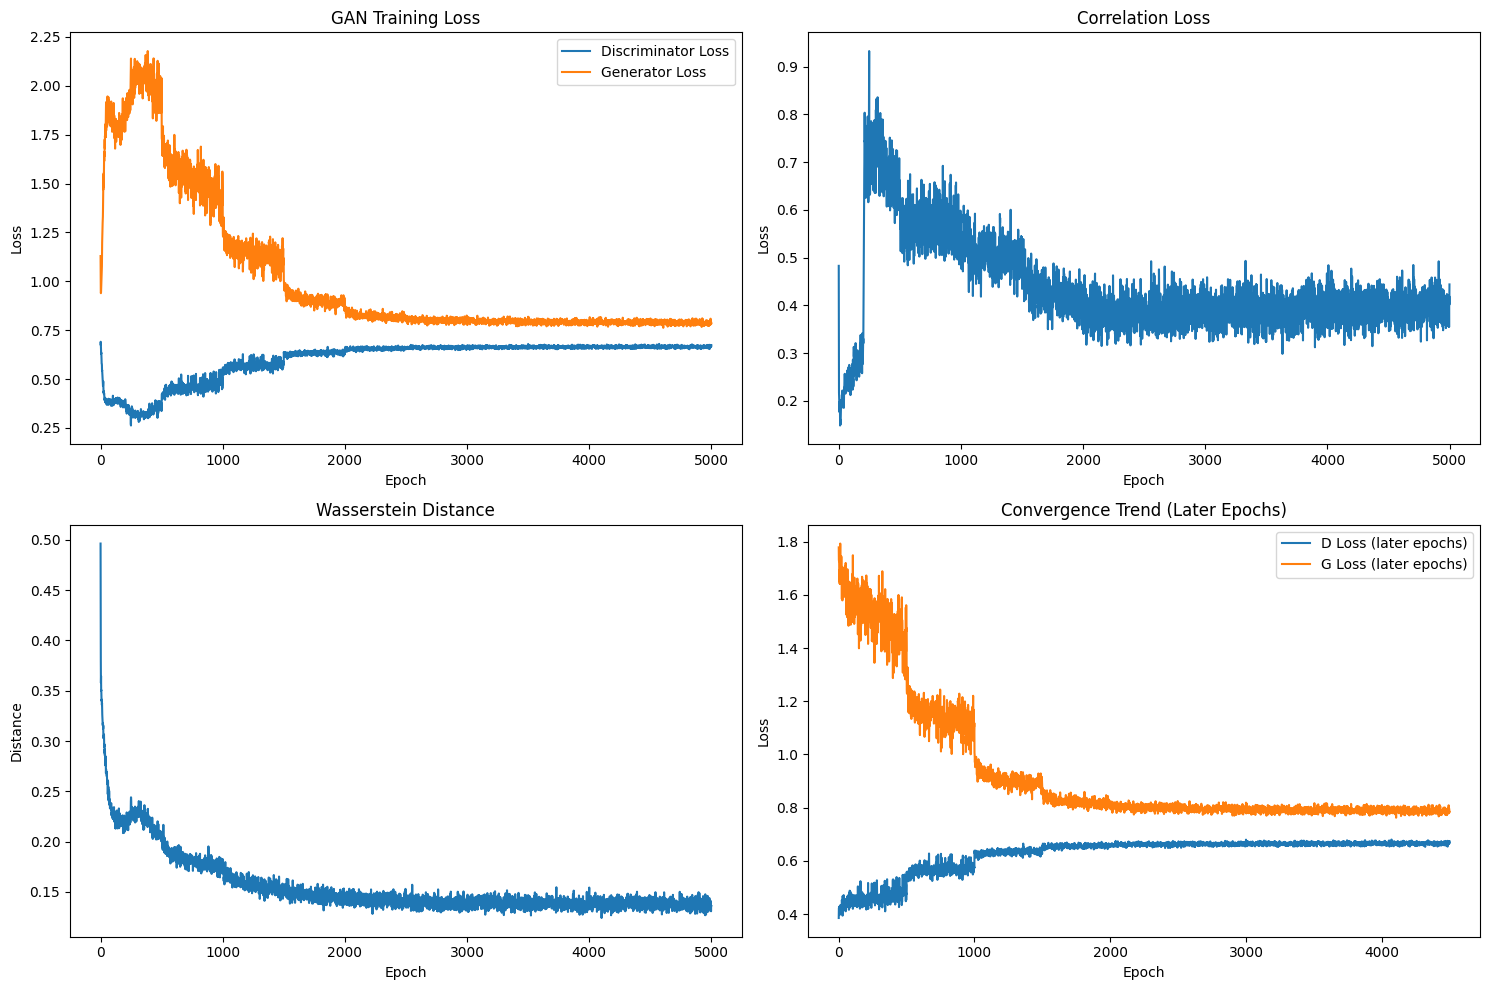

Metrics plotting completed in 0.77 seconds


In [18]:
plot_training_metrics(d_losses, g_losses, corr_losses, w_losses)


##  Generate Synthetic Data

Generate synthetic samples using the trained generator.

- **Number of Samples**: Twice the size of the original dataset, or at least 200.
- **Output**: Synthetic DataFrame with the same columns as the original data.

In [41]:
n_samples = max(200, df.shape[0] * 2)
print(f"\nGenerating {n_samples} synthetic samples...")
synthetic_df = generate_synthetic_data(generator, latent_dim, n_samples, robust_scaler, standard_scaler, device, df)
print("Synthetic data shape:", synthetic_df.shape)



Generating 2398 synthetic samples...
Starting synthetic data generation...


Generating batches: 100%|██████████| 3/3 [00:00<00:00, 34.73it/s]

Inverse transforming data...
Data generation completed in 0.09 seconds
Synthetic data shape: (2398, 10)


## Perform Check for Duplicate rows in Original data and Synthetic data

In [42]:
# Check for Copied Rows
real_array = scaled_data

# Preprocess synthetic data to the same scale and clip
preprocessed_synth = standard_scaler.transform(robust_scaler.transform(synthetic_df))
synth_array = np.clip(preprocessed_synth, -5, 5)

# Check for exact matches
matches = sum(np.any(np.all(real_array == row, axis=1)) for row in synth_array)
total_synth_rows = synth_array.shape[0]
match_percentage = (matches / total_synth_rows) * 100 if total_synth_rows > 0 else 0

print(f"Total synthetic rows: {total_synth_rows}")
print(f"Number of rows matching real data: {matches}")
print(f"Percentage of copied rows: {match_percentage:.2f}%")

if matches > 0:
    print("Warning: Synthetic data contains rows identical to real data.")
else:
    print("No rows in synthetic data match the real data exactly.")

Total synthetic rows: 2398
Number of rows matching real data: 0
Percentage of copied rows: 0.00%
No rows in synthetic data match the real data exactly.


##  Clear Memory

Free up memory to ensure efficient resource usage.

In [43]:
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()


## Visualize Distributions

Plot the distributions of real and synthetic data, including statistical metrics (mean, std, median, Wasserstein distance).

Plotting distributions...


Creating distribution plots: 100%|██████████| 10/10 [00:00<00:00, 15.59it/s]


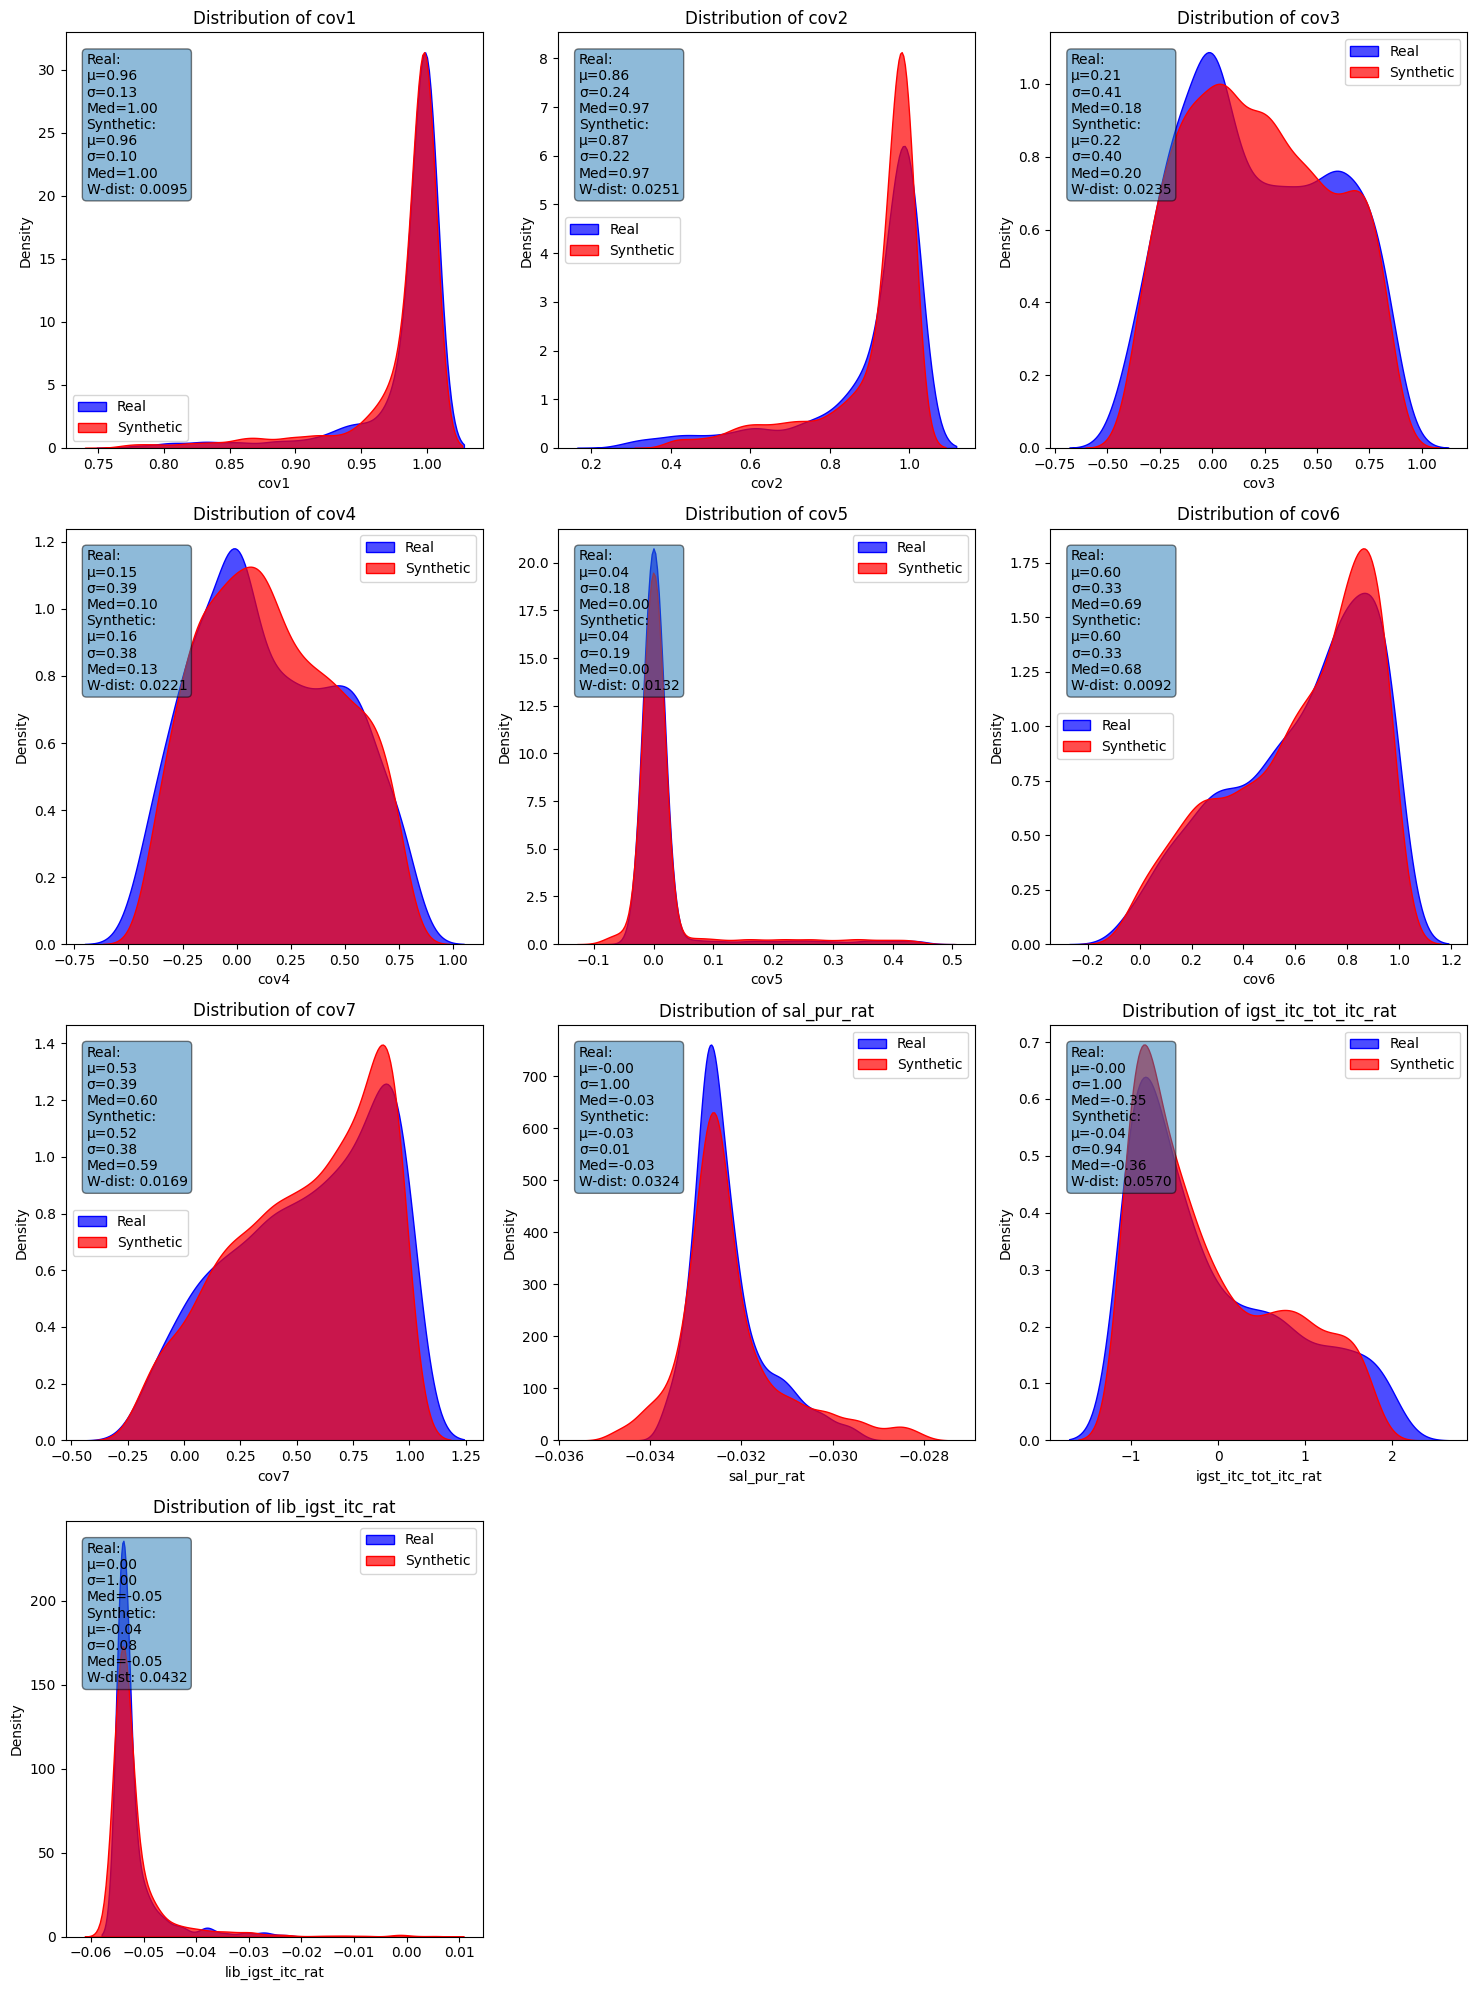

Distribution plotting completed in 1.77 seconds


In [44]:
plot_distributions(df, synthetic_df)


## Visualize Correlations

Plot correlation matrices for real and synthetic data, their differences, and Q-Q plots.

Plotting correlation comparison...


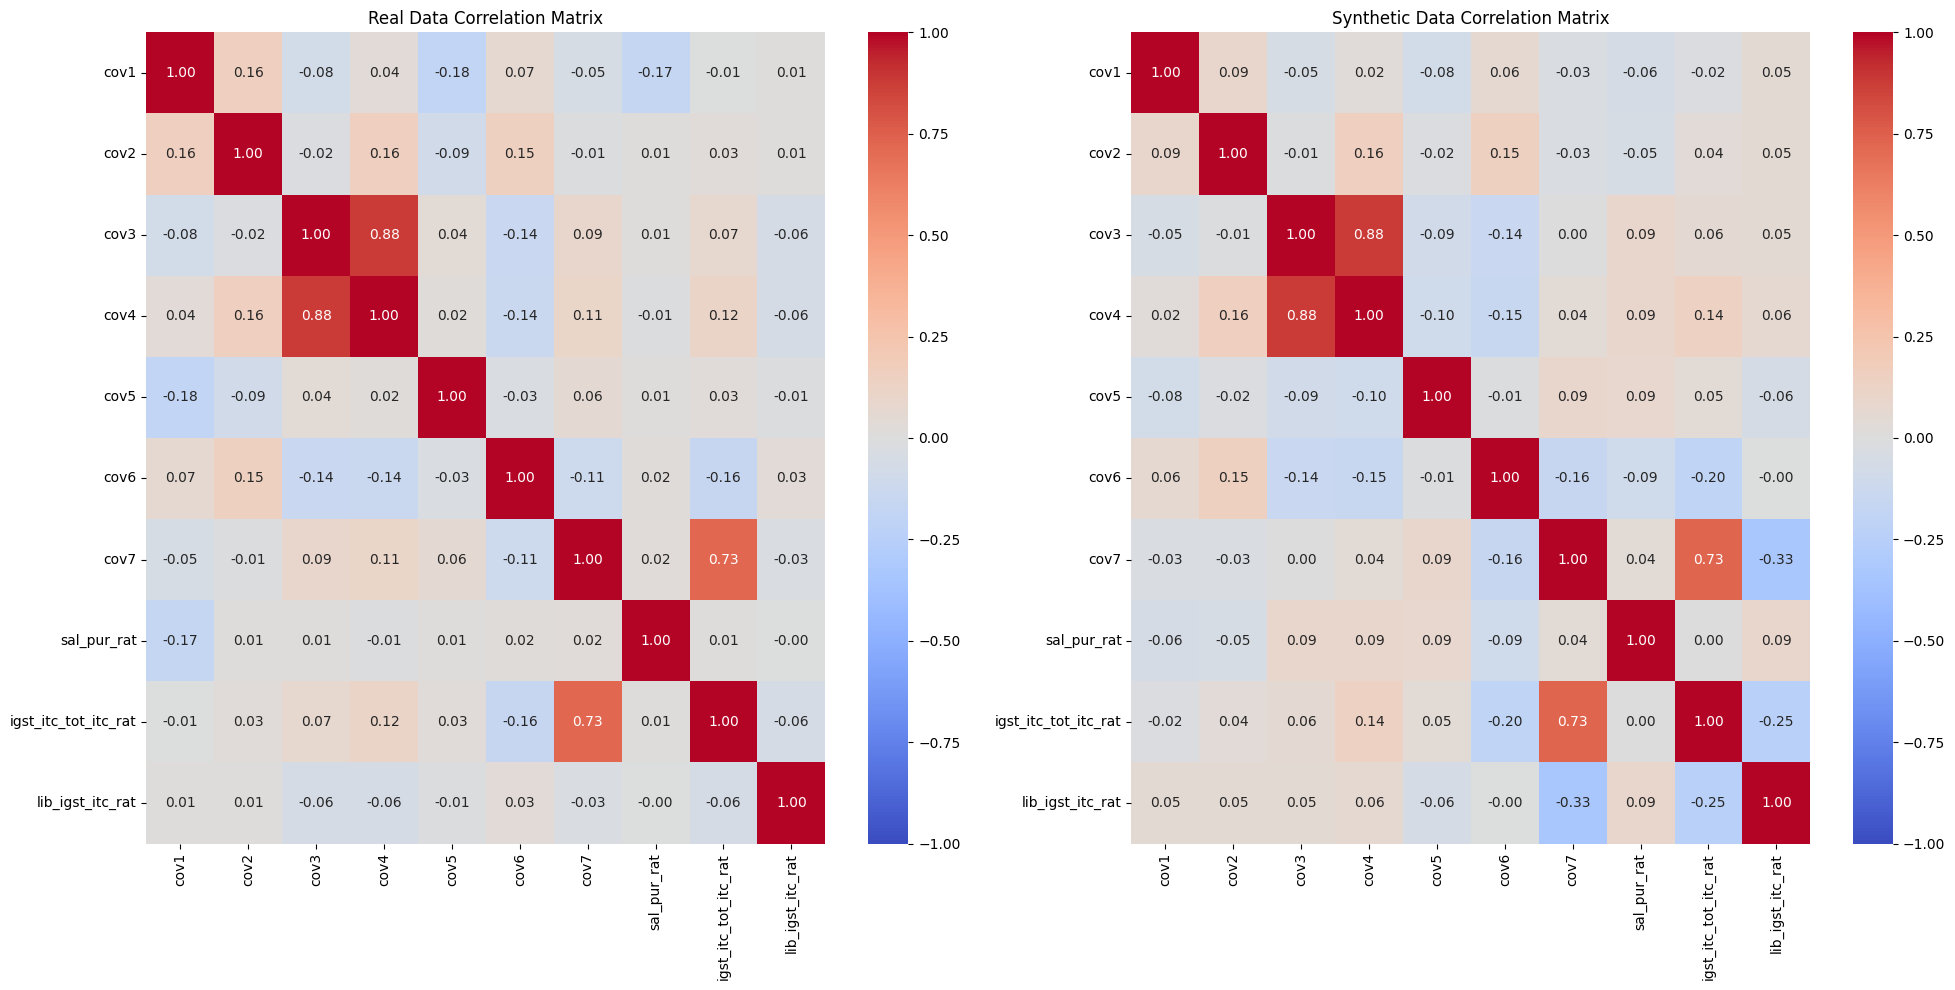

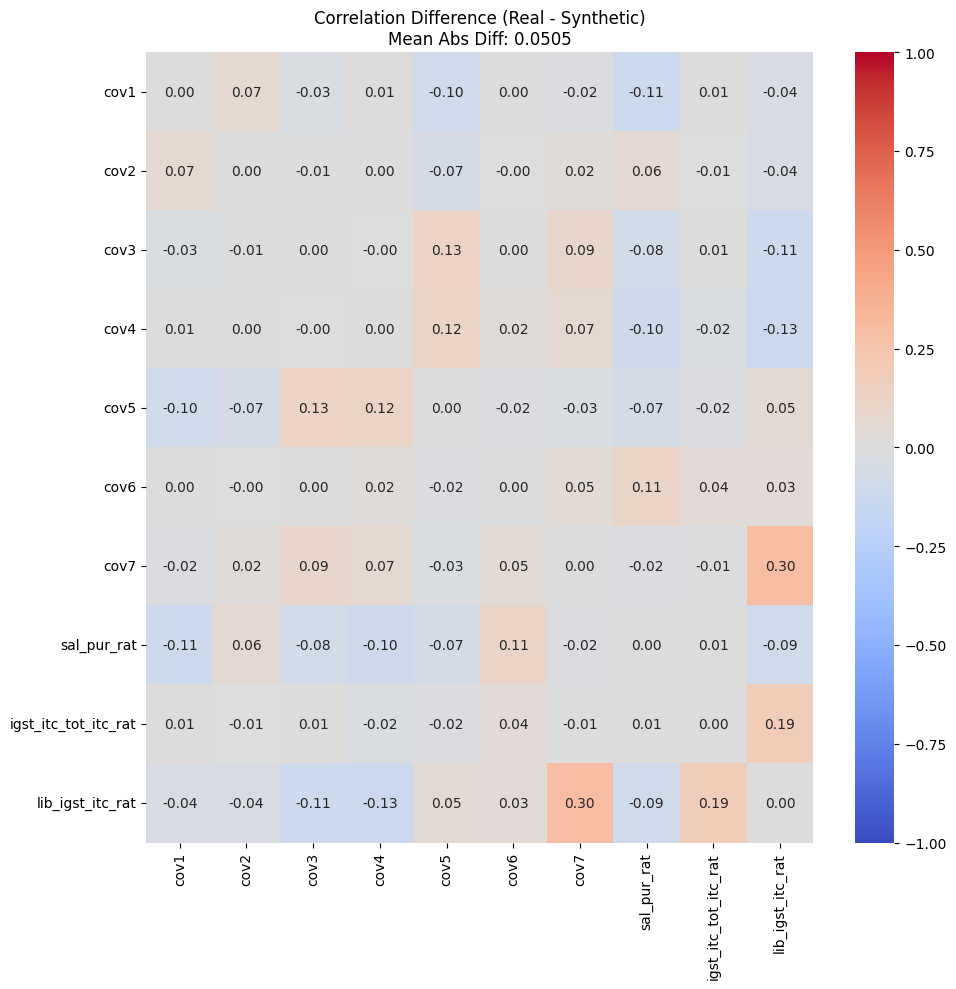

Correlation plotting completed in 1.14 seconds
Creating Q-Q plots...


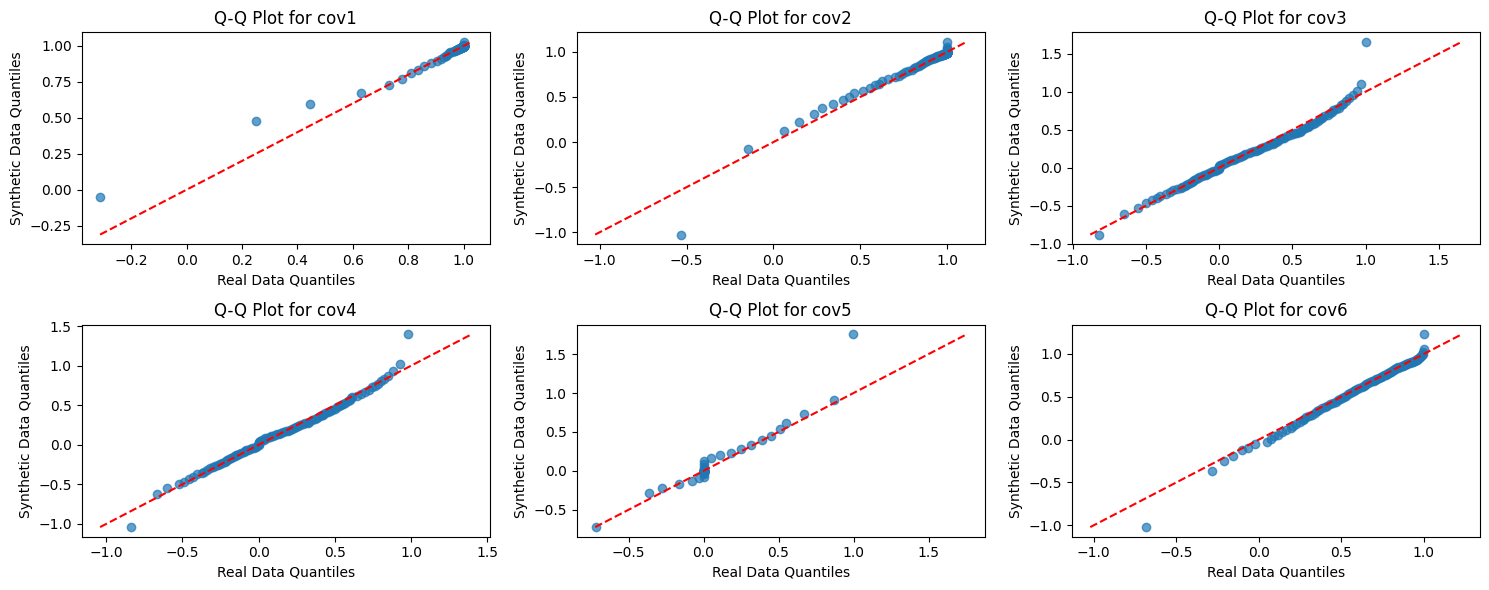

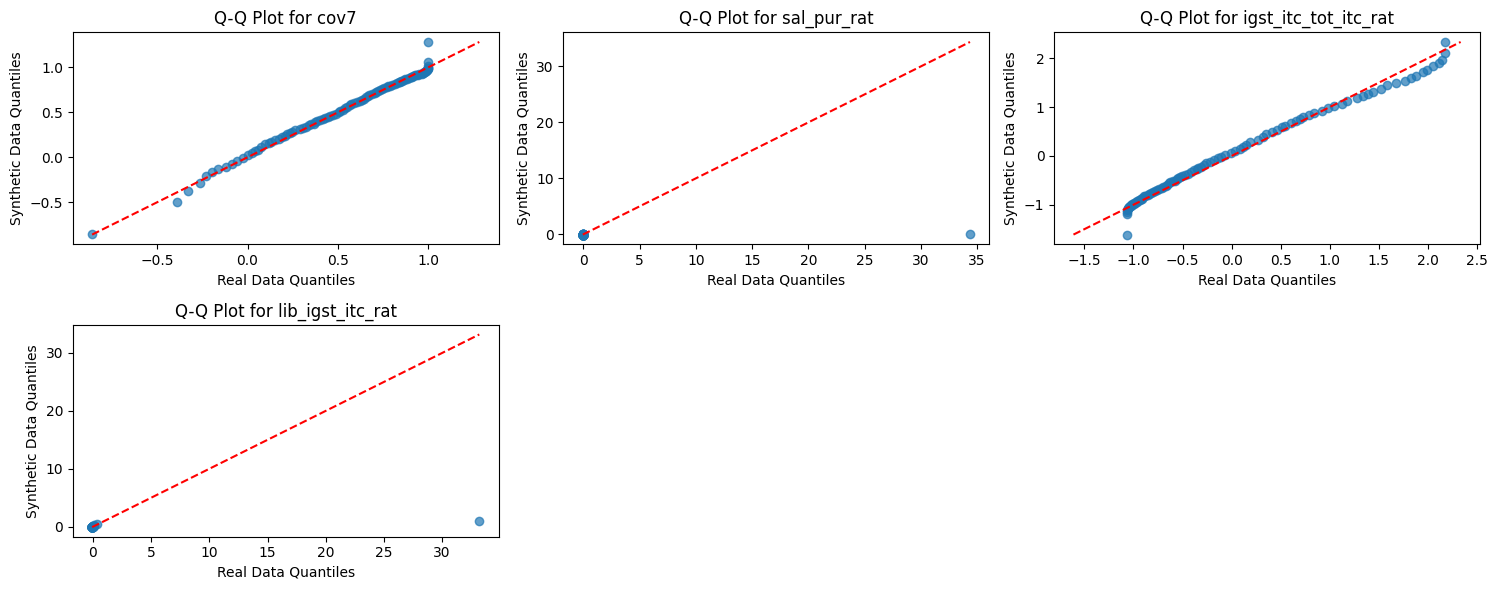

QQ-plot creation completed in 2.37 seconds


In [22]:
plot_correlation_comparison(df, synthetic_df)


## Calculate Final Metrics

Compute the mean absolute difference in correlation matrices and Wasserstein distances for each feature.

In [ ]:
# Calculate final metrics with nan protection
real_corr = safe_correlation(df.values)
synthetic_corr = safe_correlation(synthetic_df.values)
corr_diff = np.nanmean(np.abs(real_corr - synthetic_corr))  # Use nanmean to handle any potential nan values

if not np.isnan(corr_diff):
    print(f"\nCorrelation matrix mean absolute difference: {corr_diff:.4f}")
else:
    print("\nCorrelation matrix mean absolute difference: nan")

print("\nWasserstein distances between real and synthetic distributions:")
total_wd = 0
valid_wd_count = 0

for col in df.columns:
    try:
        # Remove nan values before calculating Wasserstein distance
        real_col = df[col].dropna()
        synth_col = synthetic_df[col].dropna()

        if len(real_col) > 0 and len(synth_col) > 0:
            wd = wasserstein_distance(real_col, synth_col)
            if not np.isnan(wd):
                total_wd += wd
                valid_wd_count += 1
                print(f"{col}: {wd:.4f}")
            else:
                print(f"{col}: nan")
        else:
            print(f"{col}: no valid data")
    except Exception as e:
        print(f"{col}: error - {e}")

if valid_wd_count > 0:
    print(f"Average Wasserstein distance: {total_wd/valid_wd_count:.4f}")
else:
    print("Average Wasserstein distance: could not calculate")


Correlation matrix mean absolute difference: 0.0505

Wasserstein distances between real and synthetic distributions:
cov1: 0.0085
cov2: 0.0179
cov3: 0.0308
cov4: 0.0251
cov5: 0.0162
cov6: 0.0200
cov7: 0.0200
sal_pur_rat: 0.0325
igst_itc_tot_itc_rat: 0.0788
lib_igst_itc_rat: 0.0437
Average Wasserstein distance: 0.0293


## Save Synthetic Data

Save the synthetic data to a CSV file for further analysis.

In [ ]:
print("Saving improved synthetic data to CSV...")
synthetic_df.to_csv('improved_synthetic_data.csv', index=False)

Saving improved synthetic data to CSV...


## Completion Message

Confirm that the analysis has completed successfully.

In [25]:
print("\nAnalysis completed successfully.")



Analysis completed successfully.
